# Live Maps of Flight Density Around the Globe

Text(0.5, 1.0, 'Planes')

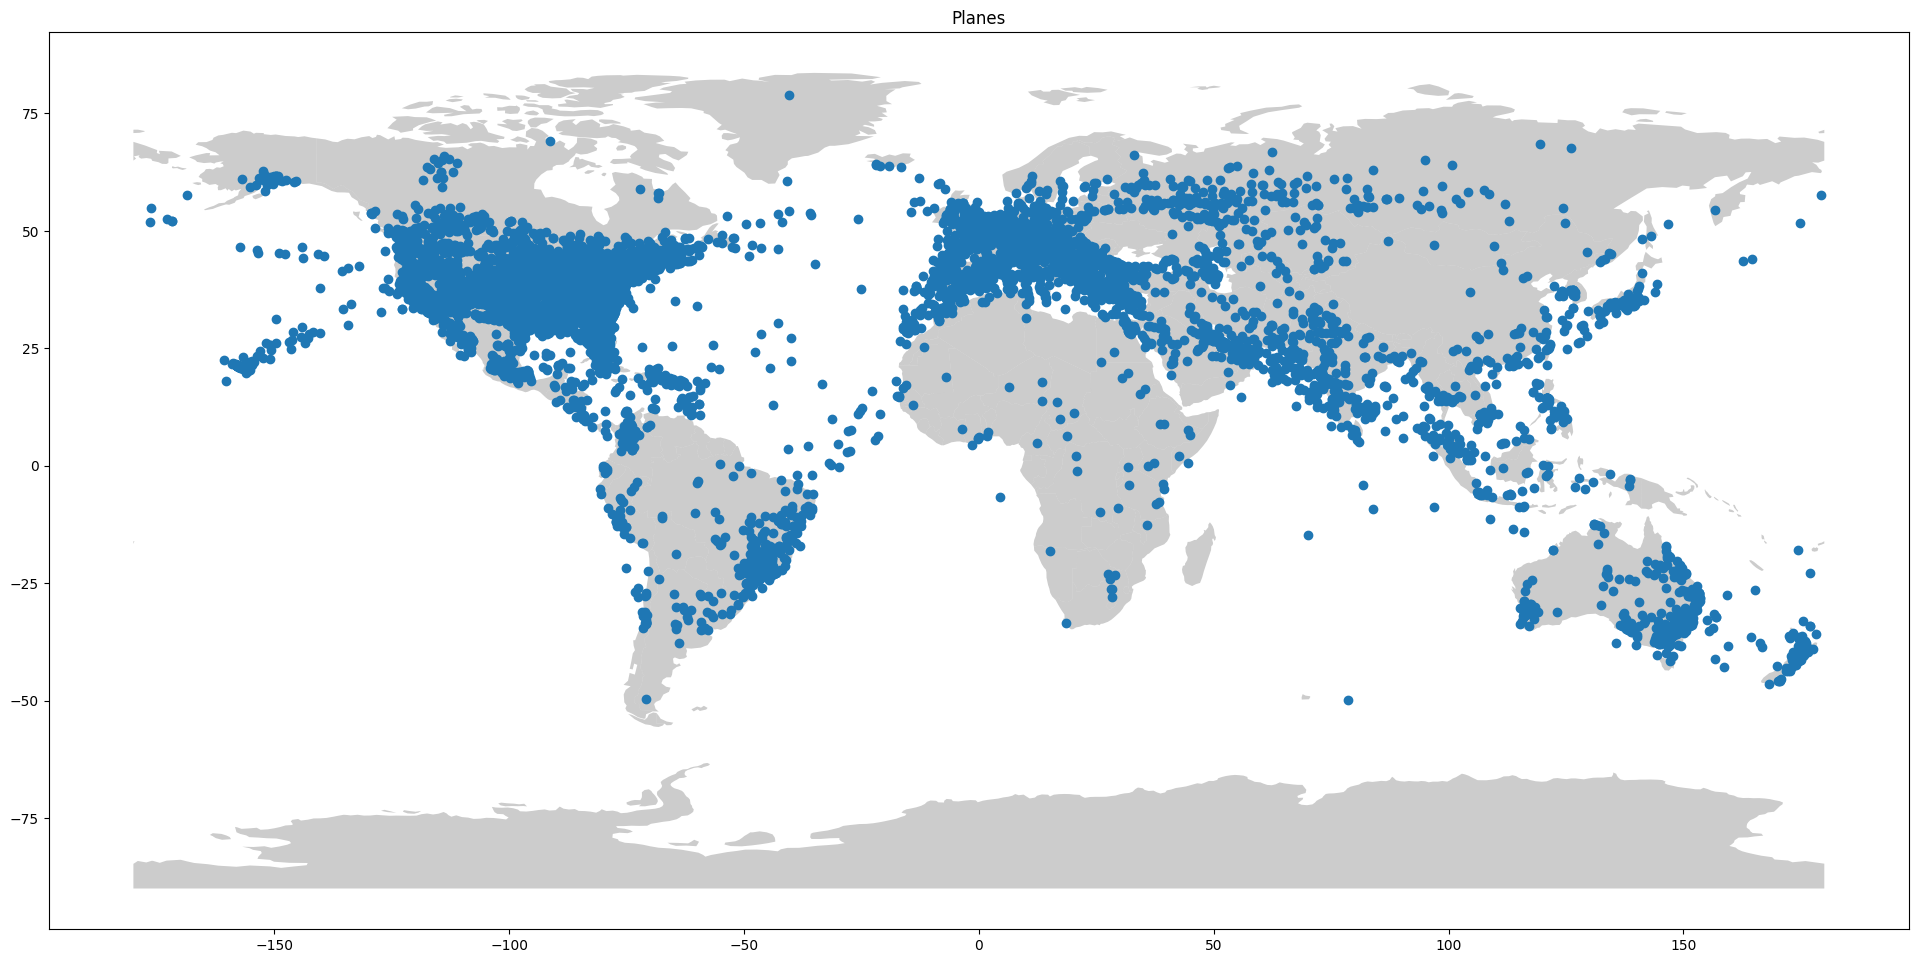

In [1]:
# Import necessary libraries
import json
import geopandas
import requests
import pandas
import folium
from folium import plugins
import matplotlib.pyplot as plt

with open("my_api_key.txt", "r") as secret:
    my_api_key = secret.read()

# Enter API key from airlabs.co account.
api_key = my_api_key

# url variable store url.
url = "https://airlabs.co/api/v9/flights?"

# GET live flight data from airlabs.co.
r = requests.get(url+"api_key="+api_key)

# Store the data in a JSON file.
filename = "flights"
file = filename+".json"
f = open(f'{file}', 'wb')
f.write(r.content)
f.close()

# Call the JSON file to extract the plane locations into a python dictionary.
# The latitudes and longitudes are stored in separate arrays with lat and lng keys.
f = open(file, "r")
json_file = json.load(f)
flights = {'lat':[], 'lng':[]}
for row in json_file["response"]:
    available_columns = row.keys()
    if "status" in available_columns:
        if row["status"] == "en-route":
            flight_info = []
            flights['lat'].append((row['lat']))
            flights['lng'].append((row['lng']))
f.close()

# Import the python dictionary into pandas DataFrame.
df = pandas.DataFrame(data=flights)

# Turn the DataFrame into GeoDataFrame which enables them to lay their positions on a map.
geo_df = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.lng, df.lat))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(24,18))
world.plot(ax=ax, alpha=0.4, color='grey')
geo_df.plot( ax=ax, legend=True)
plt.title('Planes')


## Heat Map Version

In [2]:
# Preparing a heat map.
map = folium.Map(location = [30,15], tiles='Cartodb dark_matter', zoom_start = 2)

# Use the data from the GeoDataFrame.
heat_data = [[point.xy[1][0], point.xy[0][0]] for point in geo_df.geometry ]

# Apply the data on a heatmap with some customization on symbology.
plugins.HeatMap(heat_data, blur=10, radius=11, name="Flight Density").add_to(map)

# Tools for map users.
folium.LayerControl().add_to(map)
folium.plugins.Fullscreen().add_to(map)
folium.plugins.MousePosition().add_to(map)
# folium.plugins.Geocoder().add_to(map)
# folium.plugins.MiniMap().add_to(map)

map